# Final Project Group 14 - Restaurant Recommendatiuons from Yelp Dataset

### Problem Statement:  How can we recommend restauraunts to users, what are the best places to eat?

We are going to build a recommender system to suggest the best restaurants and their offerings based on a user's location.  The goal of this notebook is to create a baseline model which can tell us some of the important features towards a recommended restaurant - ie, one which has 4 stars or better in the review.

This notebook will go through:

1. Loading the data
2. Cleaning steps
3. EDA
4. Preparing the data for our baseline naive models
5. Running 3 different naive models
6. Discussing next steps

In [1]:
!pip install geopandas

Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the 'C:\ProgramData\Anaconda3\python.exe -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

import sklearn

import matplotlib.pyplot as plt
import json
import geopandas as gpd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, Conv1D, MaxPooling1D, Flatten, SimpleRNN, LSTM, Dropout, Bidirectional

from sklearn.metrics import accuracy_score

# Load Datasets From Json Files

The datasets are stored as json files.  They are:

1. User - includes user data such as # of reviews left, average stars, etc
2. Business - includes business info such as location, category, etc
3. review - includes review info, such as user who left it, star rating, etc
4. checkin - includes checkins and time made by users
5. tip - includes tips about the place, such as "check out the secret menu item"

In [3]:
user_df = []

with open("data\yelp_academic_dataset_user.json") as f:
    reader = pd.read_json(f, orient="records", lines=True, chunksize=1000)
        
    for chunk in reader:
        reduced_chunk = chunk.drop(columns=['name'])
        user_df.append(reduced_chunk)
    
user_df  = pd.concat(user_df , ignore_index=True)

In [4]:
business_json_path = 'data/yelp_academic_dataset_business.json'
business_df = pd.read_json(business_json_path, lines=True)
business_json_path = 'data/yelp_academic_dataset_checkin.json'
checkin_df = pd.read_json(business_json_path, lines=True)
business_json_path = 'data/yelp_academic_dataset_tip.json'
tip_df = pd.read_json(business_json_path, lines=True)

In [5]:
review_df = []
r_dtypes = {"stars": np.float16, 
            "useful": np.int32, 
            "funny": np.int32,
            "cool": np.int32,
           }
with open("data\yelp_academic_dataset_review.json", "r") as f:
    reader = pd.read_json(f, orient="records", lines=True, 
                          dtype=r_dtypes, chunksize=1000)
        
    for chunk in reader:
        reduced_chunk = chunk.drop(columns=['review_id'])
        review_df.append(reduced_chunk)
    
review_df  = pd.concat(review_df , ignore_index=True)

In [6]:
business_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150346 entries, 0 to 150345
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   business_id   150346 non-null  object 
 1   name          150346 non-null  object 
 2   address       150346 non-null  object 
 3   city          150346 non-null  object 
 4   state         150346 non-null  object 
 5   postal_code   150346 non-null  object 
 6   latitude      150346 non-null  float64
 7   longitude     150346 non-null  float64
 8   stars         150346 non-null  float64
 9   review_count  150346 non-null  int64  
 10  is_open       150346 non-null  int64  
 11  attributes    136602 non-null  object 
 12  categories    150243 non-null  object 
 13  hours         127123 non-null  object 
dtypes: float64(3), int64(2), object(9)
memory usage: 16.1+ MB


In [7]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1987897 entries, 0 to 1987896
Data columns (total 21 columns):
 #   Column              Dtype  
---  ------              -----  
 0   user_id             object 
 1   review_count        int64  
 2   yelping_since       object 
 3   useful              int64  
 4   funny               int64  
 5   cool                int64  
 6   elite               object 
 7   friends             object 
 8   fans                int64  
 9   average_stars       float64
 10  compliment_hot      int64  
 11  compliment_more     int64  
 12  compliment_profile  int64  
 13  compliment_cute     int64  
 14  compliment_list     int64  
 15  compliment_note     int64  
 16  compliment_plain    int64  
 17  compliment_cool     int64  
 18  compliment_funny    int64  
 19  compliment_writer   int64  
 20  compliment_photos   int64  
dtypes: float64(1), int64(16), object(4)
memory usage: 318.5+ MB


In [8]:
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6990280 entries, 0 to 6990279
Data columns (total 8 columns):
 #   Column       Dtype         
---  ------       -----         
 0   user_id      object        
 1   business_id  object        
 2   stars        float16       
 3   useful       int32         
 4   funny        int32         
 5   cool         int32         
 6   text         object        
 7   date         datetime64[ns]
dtypes: datetime64[ns](1), float16(1), int32(3), object(3)
memory usage: 306.7+ MB


In [9]:
checkin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131930 entries, 0 to 131929
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   business_id  131930 non-null  object
 1   date         131930 non-null  object
dtypes: object(2)
memory usage: 2.0+ MB


In [10]:
tip_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 908915 entries, 0 to 908914
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   user_id           908915 non-null  object        
 1   business_id       908915 non-null  object        
 2   text              908915 non-null  object        
 3   date              908915 non-null  datetime64[ns]
 4   compliment_count  908915 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 34.7+ MB


# Number of reviews over different time

Text(0.5, 1.0, 'Number of reviews vs Years')

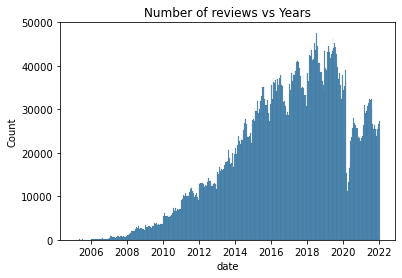

In [11]:
plot = sns.histplot(review_df["date"].dropna())
plot.set_title("Number of reviews vs Years")

# Data Cleaning

In [12]:
#only keep opening businesses with Restaurant or Food in their categories
#remove some unecessary columns
business_df = business_df.loc[business_df['is_open'] == 1]
business_new= business_df.assign(categories = business_df.categories
                         .str.split(', ')).explode('categories')
business_clean = business_new[business_new.categories.str.contains('Restaurant|Food',
                      case=False,na=False)]

business_clean = business_clean.groupby('business_id').agg({
    'name': 'first',
    'address': 'first',
    'city': 'first',
    'state': 'first',
    'postal_code': 'first',
    'latitude': 'first',
    'longitude': 'first',
    'stars': 'first',
    'review_count': 'first',
    'is_open': 'first',
    'attributes': 'first',
    'hours':'first',
    'categories': lambda x: ','.join(x)
}).reset_index()

business_clean.drop(['address', 'city', 'state', 'is_open'], axis=1, inplace=True)

#remove the reviews before 2012
review_clean = review_df.loc[review_df["date"].dt.year >= 2012]

#remove the users with an average of 1 star or 5 stars
user_clean = user_df[(user_df["average_stars"] > 1 ) & (user_df["average_stars"]  < 5)]

In [13]:
business_new.categories.value_counts()

Restaurants               34987
Food                      20419
Shopping                  20186
Home Services             13322
Beauty & Spas             12263
                          ...  
Guamanian                     1
Cheese Tasting Classes        1
Bike Repair                   1
Tonkatsu                      1
Trade Fairs                   1
Name: categories, Length: 1302, dtype: int64

In [14]:
# keep all three major datasets updated
review_clean = review_clean.loc[review_clean['business_id'].isin(business_clean["business_id"])]
user_clean = user_df.loc[user_df['user_id'].isin(review_clean["user_id"])]
business_clean = business_clean.loc[business_clean["business_id"].isin(review_clean["business_id"])]


# Check the sum/percentage of nans

In [15]:
business_clean.isna().sum()

business_id        0
name               0
postal_code        0
latitude           0
longitude          0
stars              0
review_count       0
attributes       705
hours           4715
categories         0
dtype: int64

In [16]:
user_clean.isna().sum()

user_id               0
review_count          0
yelping_since         0
useful                0
funny                 0
cool                  0
elite                 0
friends               0
fans                  0
average_stars         0
compliment_hot        0
compliment_more       0
compliment_profile    0
compliment_cute       0
compliment_list       0
compliment_note       0
compliment_plain      0
compliment_cool       0
compliment_funny      0
compliment_writer     0
compliment_photos     0
dtype: int64

In [17]:
review_clean.isna().sum()

user_id        0
business_id    0
stars          0
useful         0
funny          0
cool           0
text           0
date           0
dtype: int64

<AxesSubplot:>

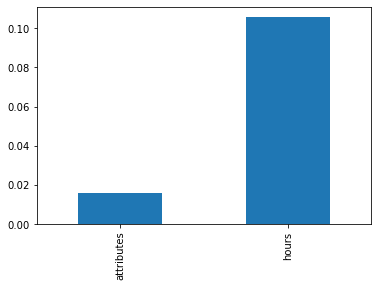

In [18]:
business_clean.notnull().mean().sub(1).mul(-1).replace(0, np.nan).dropna().sort_values().plot.bar()

In [19]:
business_clean.head()

,business_id,name,postal_code,latitude,longitude,stars,review_count,attributes,hours,categories
0,---kPU91CF4Lq2-WlRu9Lw,Frankie's Raw Bar,34652,28.217288,-82.733344,4.5,24,"{'Alcohol': 'u'none'', 'OutdoorSeating': 'True...","{'Monday': '0:0-0:0', 'Tuesday': '11:0-21:0', ...","Seafood,Restaurants,Food,Food Trucks"
1,--0iUa4sNDFiZFrAdIWhZQ,Pupuseria Y Restaurant Melba,08021,39.817850,-74.993364,3.0,14,"{'Alcohol': 'u'none'', 'RestaurantsDelivery': ...",None,"Food,Restaurants,Specialty Food,Ethnic Food,Im..."
2,--SJXpAa0E-GCp2smaHf0A,Winn Dixie,33579,27.791333,-82.332240,2.5,13,"{'BikeParking': 'False', 'RestaurantsPriceRang...","{'Monday': '7:0-23:0', 'Tuesday': '7:0-23:0', ...",Food
3,--epgcb7xHGuJ-4PUeSLAw,Manhattan Bagel,19090,40.145054,-75.116293,3.0,34,"{'BikeParking': 'True', 'RestaurantsPriceRange...","{'Monday': '7:0-14:0', 'Tuesday': '7:0-14:0', ...","Restaurants,Food"
4,--hF_3v1JmU9nlu4zfXJ8Q,Green District Salads - Monument Circle,46204,39.767888,-86.158351,4.5,15,"{'Alcohol': 'u'beer_and_wine'', 'OutdoorSeatin...","{'Monday': '0:0-0:0', 'Tuesday': '11:0-16:0', ...",Restaurants


In [20]:
review_clean.head()

,user_id,business_id,stars,useful,funny,cool,text,date
0,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
2,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
9,59MxRhNVhU9MYndMkz0wtw,gebiRewfieSdtt17PTW6Zg,3.0,0,0,0,Had a party of 6 here for hibachi. Our waitres...,2016-07-25 07:31:06
11,ZbqSHbgCjzVAqaa7NKWn5A,EQ-TZ2eeD_E0BHuvoaeG5Q,4.0,0,0,0,"Locals recommended Milktooth, and it's an amaz...",2015-08-19 14:31:45


In [21]:
user_clean.head()

,user_id,review_count,yelping_since,useful,funny,cool,elite,friends,fans,average_stars,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,qVc8ODYU5SZjKXVBgXdI7w,585,2007-01-25 16:47:26,7217,1259,5994,2007,"NSCy54eWehBJyZdG2iE84w, pe42u7DcCH2QmI81NX-8qA...",267,3.91,...,65,55,56,18,232,844,467,467,239,180
1,j14WgRoU_-2ZE1aw1dXrJg,4333,2009-01-25 04:35:42,43091,13066,27281,"2009,2010,2011,2012,2013,2014,2015,2016,2017,2...","ueRPE0CX75ePGMqOFVj6IQ, 52oH4DrRvzzl8wh5UXyU0A...",3138,3.74,...,264,184,157,251,1847,7054,3131,3131,1521,1946
4,hA5lMy-EnncsH4JoR-hFGQ,79,2007-01-05 19:40:59,29,15,7,,"PBK4q9KEEBHhFvSXCUirIw, 3FWPpM7KU1gXeOM_ZbYMbA...",1,3.54,...,1,0,0,0,1,1,0,0,0,0
5,q_QQ5kBBwlCcbL1s4NVK3g,1221,2005-03-14 20:26:35,14953,9940,11211,"2006,2007,2008,2009,2010,2011,2012,2013,2014","xBDpTUbai0DXrvxCe3X16Q, 7GPNBO496aecrjJfW6UWtg...",1357,3.85,...,163,191,361,147,1212,5696,2543,2543,815,323
7,E9kcWJdJUHuTKfQurPljwA,358,2008-12-11 22:11:56,399,102,143,,"y2GyxJF5VQWohxgw_GR7Jw, 0NRn4eY3JWN0IFqvOSa5gA...",23,3.73,...,7,2,0,0,8,6,12,12,5,0


# Graphs to show some properties of the datasets

Text(0.5, 1.0, 'Distribution of log10(review_count) by business')

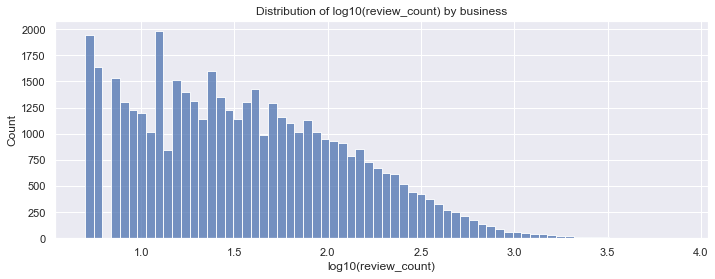

In [22]:
sns.set(rc={'figure.figsize':(11.7,4)})
plot = sns.histplot(np.log10(business_clean["review_count"]).dropna())
plot.set_xlabel("log10(review_count)")
plot.set_title("Distribution of log10(review_count) by business")

Text(0.5, 1.0, 'Distribution of stars by business')

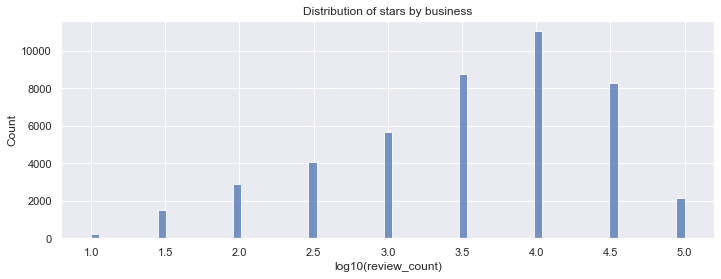

In [23]:
plot = sns.histplot(business_clean["stars"].dropna())
plot.set_xlabel("log10(review_count)")
plot.set_title("Distribution of stars by business")

Text(0.5, 1.0, "Features' heatmap")

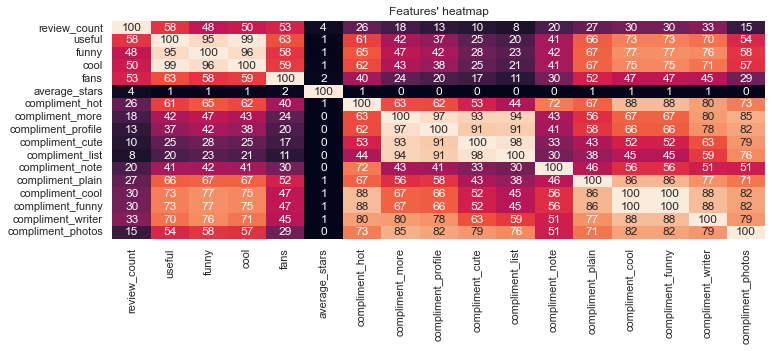

In [24]:
ax = sns.heatmap(
    user_clean.corr() * 100,
    annot=True,
    cbar=False,
    fmt='.0f',
    # mask=np.triu()
)
ax.set_title("Features' heatmap")

In [25]:
pd.options.display.max_colwidth = 100

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 1.0, 'Distribution of log10(review_count) by user')

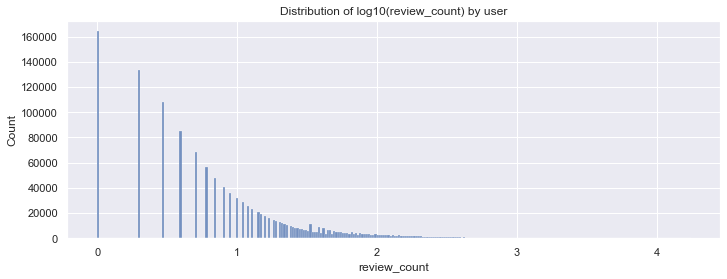

In [26]:
plot = sns.histplot(np.log10(user_clean["review_count"]).dropna())
plot.set_title("Distribution of log10(review_count) by user")

C:\Users\mofei\AppData\Local\Temp\ipykernel_9152\1045789567.py:13: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(label='stars')


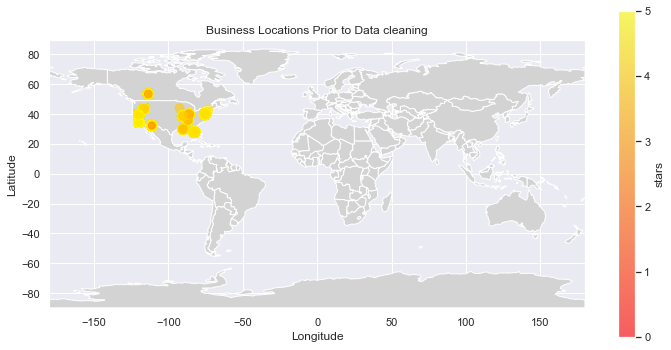

In [27]:
worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# Creating axes and plotting world map
fig, ax = plt.subplots(figsize=(12, 6))
worldmap.plot(color="lightgrey", ax=ax)

# Plotting our Impact Energy data with a color map
x = business_df['longitude']
y = business_df['latitude']
z = business_df['stars']
plt.scatter(x, y, s=20*z, c=z, alpha=0.6, vmin=0, vmax=5,
            cmap='autumn')
plt.colorbar(label='stars')

# Creating axis limits and title
plt.xlim([-180, 180])
plt.ylim([-90, 90])

plt.title("Business Locations Prior to Data cleaning")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

# Create response variable and remove unnecessary variables

We will be using "is_recommended" as a response variable, built where if a business has 4 stars or better, it is recommended, otherwise it is not.

In [28]:
baseline_dataset = business_clean.copy()
baseline_dataset["is_recommended"] = np.where(baseline_dataset['stars']>=4, 1, 0)
baseline_dataset = baseline_dataset.drop(['name','postal_code','hours','stars'], axis=1)

# One-hot encode categories

In [29]:
baseline_dataset_encoded = baseline_dataset['categories'].str.get_dummies(sep=',')

# Add the encoded categories to the original dataframe
baseline_dataset = pd.concat([baseline_dataset, baseline_dataset_encoded], axis=1)

# Drop the original categories column
baseline_dataset.drop("categories", axis=1, inplace=True)

# Drop null for attributes and one-hot encode it

In [30]:
baseline_dataset = baseline_dataset.dropna(subset=['attributes'])
baseline_dataset =baseline_dataset.reset_index(drop=True)

In [31]:
attribute_names = set()
for attributes in baseline_dataset['attributes']:
    attribute_names |= set(attributes.keys())

# create a dictionary to hold the one-hot encoded attributes
attribute_dict = {}
for attribute_name in attribute_names:
    attribute_dict[attribute_name] = []

# iterate over the attributes column and one-hot encode each attribute
for attributes in baseline_dataset['attributes']:
    for attribute_name in attribute_names:
        if attribute_name in attributes:
            attribute_dict[attribute_name].append(1 if attributes[attribute_name] == 'True' else 0)
        else:
            attribute_dict[attribute_name].append(0)

# create a dataframe from the attribute dictionary
attribute_baseline_dataset = pd.DataFrame(attribute_dict)

# concatenate the original dataframe with the attribute dataframe
baseline_dataset = pd.concat([baseline_dataset, attribute_baseline_dataset], axis=1)

# drop the original attributes column
baseline_dataset.drop('attributes', axis=1, inplace=True)


# merge some variables from review_dataframe

Since we have a number of different datasets, we will merge them into one.  This join is on business id, where we compress it to unique business ids on the business table only.  The groupby does this aggregation.

In [32]:
useful_reviews = review_clean.groupby('business_id')['useful'].sum()
funny_reviews = review_clean.groupby('business_id')['funny'].sum()
cool_reviews = review_clean.groupby('business_id')['cool'].sum()

useful_reviews_df = pd.DataFrame({'business_id': useful_reviews.index, 'useful_reviews': useful_reviews.values})
funny_reviews_df = pd.DataFrame({'business_id': funny_reviews.index, 'funny_reviews': funny_reviews.values})
cool_reviews_df = pd.DataFrame({'business_id': cool_reviews.index, 'cool_reviews': cool_reviews.values})

In [33]:
useful_reviews_df = useful_reviews_df[useful_reviews_df.business_id.isin(baseline_dataset.business_id)]
funny_reviews_df = funny_reviews_df[funny_reviews_df.business_id.isin(baseline_dataset.business_id)]
cool_reviews_df = cool_reviews_df[cool_reviews_df.business_id.isin(baseline_dataset.business_id)]

In [34]:
baseline_dataset = pd.merge(baseline_dataset, useful_reviews_df, on='business_id', how='left')
baseline_dataset = pd.merge(baseline_dataset, funny_reviews_df, on='business_id', how='left')
baseline_dataset = pd.merge(baseline_dataset, cool_reviews_df, on='business_id', how='left')

In [35]:
baseline_dataset.drop('business_id', axis=1, inplace=True)

# Create train/test datasets

In [36]:
X = baseline_dataset.drop(['is_recommended'], axis=1)
y = baseline_dataset['is_recommended']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=109)

# Scale the x variables

In [37]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a naive model

Our naive model is just a basic feed-forward neural network.

In [38]:

epochs = 100
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(X_train.shape[1], ))) 
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu', kernel_regularizer='l2'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu', kernel_regularizer='l2'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu', kernel_regularizer='l2'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')


history = model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=epochs, batch_size=32)

Epoch 1/100
878/878 [==============================] - 4s 4ms/step - loss: 0.9093 - accuracy: 0.6923 - val_loss: 0.5931 - val_accuracy: 0.7081
Epoch 2/100
878/878 [==============================] - 3s 4ms/step - loss: 0.5835 - accuracy: 0.7164 - val_loss: 0.5752 - val_accuracy: 0.7207
Epoch 3/100
878/878 [==============================] - 4s 4ms/step - loss: 0.5728 - accuracy: 0.7232 - val_loss: 0.5604 - val_accuracy: 0.7270
Epoch 4/100
878/878 [==============================] - 3s 4ms/step - loss: 0.5600 - accuracy: 0.7347 - val_loss: 0.5568 - val_accuracy: 0.7287
Epoch 5/100
878/878 [==============================] - 3s 4ms/step - loss: 0.5550 - accuracy: 0.7333 - val_loss: 0.5541 - val_accuracy: 0.7318
Epoch 6/100
878/878 [==============================] - 4s 4ms/step - loss: 0.5482 - accuracy: 0.7419 - val_loss: 0.5472 - val_accuracy: 0.7418
Epoch 7/100
878/878 [==============================] - 4s 4ms/step - loss: 0.5461 - accuracy: 0.7422 - val_loss: 0.5441 - val_accuracy: 0.7414

C:\Users\mofei\AppData\Local\Temp\ipykernel_9152\1778633139.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.2980392156862745, 0.4470588235294118, 0.6901960784313725, 1)). The keyword argument will take precedence.
  plt.plot(range(1,epochs+1), train_acc, 'b', label='train accuracy',color="blue")
C:\Users\mofei\AppData\Local\Temp\ipykernel_9152\1778633139.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.2980392156862745, 0.4470588235294118, 0.6901960784313725, 1)). The keyword argument will take precedence.
  plt.plot(range(1,epochs+1), val_acc, 'b', label='validation accuracy',color="red")


<Figure size 842.4x288 with 0 Axes>

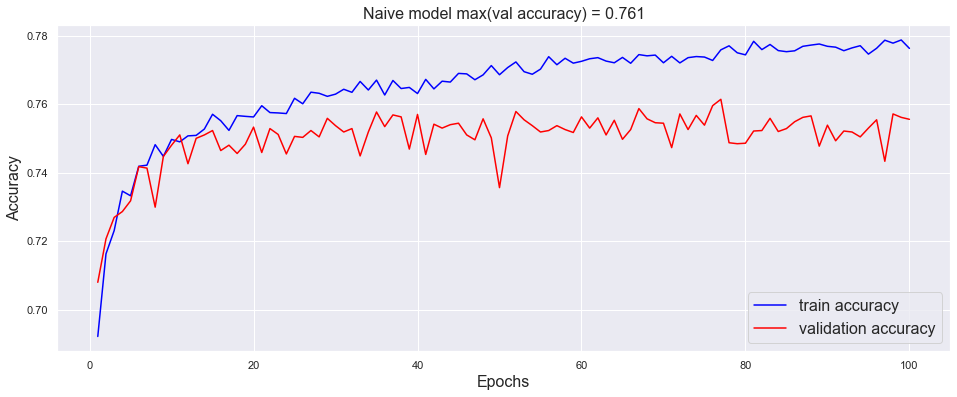

In [39]:
plt.clf()
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(16,6))
plt.plot(range(1,epochs+1), train_acc, 'b', label='train accuracy',color="blue")
plt.plot(range(1,epochs+1), val_acc, 'b', label='validation accuracy',color="red")

plt.title('Naive model max(val accuracy) = ' + str(round(max(val_acc),3)),fontsize=16)
plt.xlabel('Epochs',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.grid(True)
plt.legend(loc = 'lower right',fontsize=16)

plt.show()

In [40]:
x_train_reshape = X_train_scaled.copy()
x_test_reshape = X_test_scaled.copy()
x_train_reshape = np.reshape(x_train_reshape, (x_train_reshape.shape[0], x_train_reshape.shape[1], 1))
x_test_reshape = np.reshape(x_test_reshape, (x_test_reshape.shape[0], x_test_reshape.shape[1], 1))

#  Create a naive  simplernn model

In [41]:
model1 = Sequential()
model1.add(SimpleRNN(128, input_shape=(None, 1)))
model1.add(Dense(1, activation='sigmoid'))


model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


history1 = model1.fit(x_train_reshape, y_train, epochs=epochs,validation_split=0.2, batch_size=32)

Epoch 1/100
878/878 [==============================] - 23s 26ms/step - loss: 0.5963 - accuracy: 0.6656 - val_loss: 0.5658 - val_accuracy: 0.6925
Epoch 2/100
878/878 [==============================] - 21s 24ms/step - loss: 0.5690 - accuracy: 0.6957 - val_loss: 0.5658 - val_accuracy: 0.6947
Epoch 3/100
878/878 [==============================] - 22s 25ms/step - loss: 0.5557 - accuracy: 0.7059 - val_loss: 0.5400 - val_accuracy: 0.7200
Epoch 4/100
878/878 [==============================] - 22s 25ms/step - loss: 0.5496 - accuracy: 0.7142 - val_loss: 0.5311 - val_accuracy: 0.7284
Epoch 5/100
878/878 [==============================] - 22s 25ms/step - loss: 0.5440 - accuracy: 0.7191 - val_loss: 0.5420 - val_accuracy: 0.7263
Epoch 6/100
878/878 [==============================] - 22s 25ms/step - loss: 0.5490 - accuracy: 0.7149 - val_loss: 0.5334 - val_accuracy: 0.7254
Epoch 7/100
878/878 [==============================] - 22s 25ms/step - loss: 0.5641 - accuracy: 0.6988 - val_loss: 0.5973 - val_ac

C:\Users\mofei\AppData\Local\Temp\ipykernel_9152\1588482992.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.2980392156862745, 0.4470588235294118, 0.6901960784313725, 1)). The keyword argument will take precedence.
  plt.plot(range(1,epochs+1), train_acc, 'b', label='train accuracy',color="blue")
C:\Users\mofei\AppData\Local\Temp\ipykernel_9152\1588482992.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.2980392156862745, 0.4470588235294118, 0.6901960784313725, 1)). The keyword argument will take precedence.
  plt.plot(range(1,epochs+1), val_acc, 'b', label='validation accuracy',color="red")


<Figure size 842.4x288 with 0 Axes>

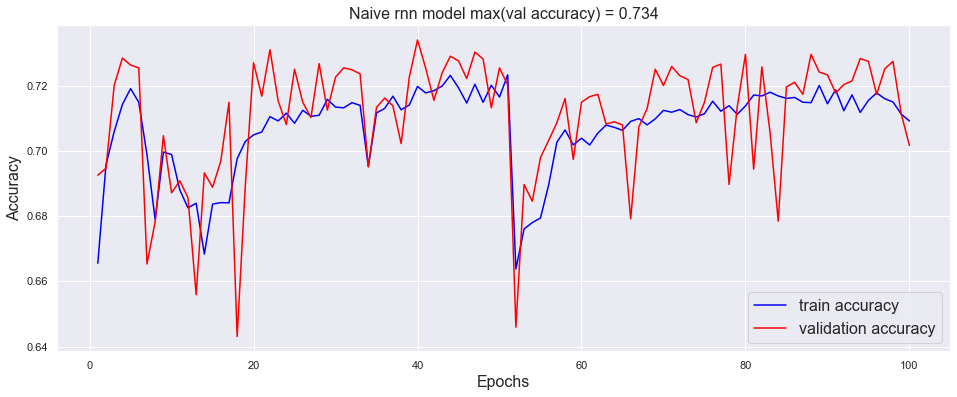

In [42]:
plt.clf()
train_acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

plt.figure(figsize=(16,6))
plt.plot(range(1,epochs+1), train_acc, 'b', label='train accuracy',color="blue")
plt.plot(range(1,epochs+1), val_acc, 'b', label='validation accuracy',color="red")

plt.title('Naive rnn model max(val accuracy) = ' + str(round(max(val_acc),3)),fontsize=16)
plt.xlabel('Epochs',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.grid(True)
plt.legend(loc = 'lower right',fontsize=16)

plt.show()

# Create a naive cnn model

In [43]:
model2 = Sequential()

model2.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(65, 1)))
model2.add(MaxPooling1D(pool_size=2))
model2.add(Flatten())
model2.add(Dense(64, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history2 = model2.fit(x_train_reshape, y_train, epochs=epochs,validation_split=0.2, batch_size=32)

Epoch 1/100
878/878 [==============================] - 9s 10ms/step - loss: 0.5811 - accuracy: 0.6865 - val_loss: 0.5730 - val_accuracy: 0.6991
Epoch 2/100
878/878 [==============================] - 8s 9ms/step - loss: 0.5661 - accuracy: 0.6993 - val_loss: 0.5641 - val_accuracy: 0.6995
Epoch 3/100
878/878 [==============================] - 8s 9ms/step - loss: 0.5600 - accuracy: 0.7023 - val_loss: 0.5656 - val_accuracy: 0.6961
Epoch 4/100
878/878 [==============================] - 8s 9ms/step - loss: 0.5555 - accuracy: 0.7074 - val_loss: 0.5672 - val_accuracy: 0.6950
Epoch 5/100
878/878 [==============================] - 8s 9ms/step - loss: 0.5525 - accuracy: 0.7111 - val_loss: 0.5591 - val_accuracy: 0.7026
Epoch 6/100
878/878 [==============================] - 8s 9ms/step - loss: 0.5499 - accuracy: 0.7126 - val_loss: 0.5639 - val_accuracy: 0.7048
Epoch 7/100
878/878 [==============================] - 8s 9ms/step - loss: 0.5485 - accuracy: 0.7140 - val_loss: 0.5644 - val_accuracy: 0.699

C:\Users\mofei\AppData\Local\Temp\ipykernel_9152\3879725086.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.2980392156862745, 0.4470588235294118, 0.6901960784313725, 1)). The keyword argument will take precedence.
  plt.plot(range(1,epochs+1), train_acc, 'b', label='train accuracy',color="blue")
C:\Users\mofei\AppData\Local\Temp\ipykernel_9152\3879725086.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.2980392156862745, 0.4470588235294118, 0.6901960784313725, 1)). The keyword argument will take precedence.
  plt.plot(range(1,epochs+1), val_acc, 'b', label='validation accuracy',color="red")


<Figure size 842.4x288 with 0 Axes>

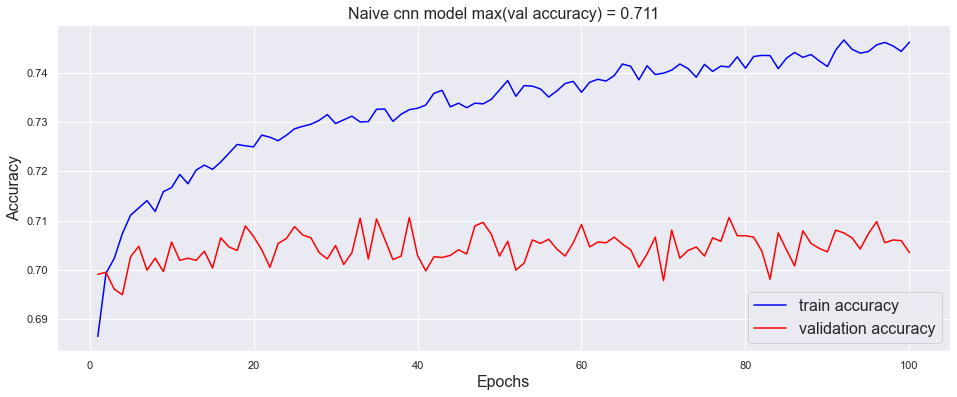

In [44]:
plt.clf()
train_acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

plt.figure(figsize=(16,6))
plt.plot(range(1,epochs+1), train_acc, 'b', label='train accuracy',color="blue")
plt.plot(range(1,epochs+1), val_acc, 'b', label='validation accuracy',color="red")

plt.title('Naive cnn model max(val accuracy) = ' + str(round(max(val_acc),3)),fontsize=16)
plt.xlabel('Epochs',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.grid(True)
plt.legend(loc = 'lower right',fontsize=16)

plt.show()

# Display final results

In [45]:
y_pred = model.predict(X_test_scaled).round()
naive_score = accuracy_score(y_pred, y_test)
y_pred1 = model1.predict(x_test_reshape).round()
rnn_naive_score = accuracy_score(y_pred1, y_test)
y_pred2 = model2.predict(x_test_reshape).round()
cnn_naive_score = accuracy_score(y_pred2, y_test)

275/275 [==============================] - 1s 3ms/step


In [46]:
naive_accuracy_scores =pd.DataFrame({'naive_model': [naive_score] ,
        'rnn_naive_model': [rnn_naive_score],
        'cnn_naive_model': [cnn_naive_score]})
naive_accuracy_scores

,naive_model,rnn_naive_model,cnn_naive_model
0,0.750598,0.700467,0.700011


# Baseline Model

We experimented with a few different kinds of models, FFNN, RNN, and CNN.  Since our inputs are factors predicting if a restaurant is good or not, it makes sense the naive ffnn gives the best results, as CNN and RNN are better suited for different tasks.

One consideration we had was performing sentiment analysis on review text - however, since all reviews must come with a star rating, and the star rating makes sense for an output of that task, it seemed like this would not provide much value.


# Future Steps

An approach we would like to try for the final model is a clustering method, where we take businesses from specific areas, find all the users who have rated them, and try to group those users by similarity - ie, if user A has reviewed restaurant 1, 2, and 3 with good reviews and restaurant 4 with a bad reveiw, and user B has reviewed restaurant 1, 2, and 4 the same, but has not reviewed restaurant 3, we will see the two users be considered "similar", and try to recommend restaurants based on that.